## 부탁 드립니다!

본 자료는 패스트캠퍼스 RAG 비법노트 강의에서 유료 강의로 제공되는 자료입니다. 

따라서, 제공된 코드를 사용하여 개발하는 것은 얼마든지 가능합니다만,

**제 3자 에게 무단배포, 웹에 소스코드 게재 및 배포는 금지**하고 있다는 점 부디 양해해 주시기 바랍니다.

개발 및 학습 목적으로만 활용해 주세요. 많은 도움이 되었으면 좋겠습니다. 늘 감사드립니다.

## 환경 설정


In [7]:
from dotenv import load_dotenv

load_dotenv()

True

In [8]:
from langchain_teddynote import logging

logging.langsmith("TeddyNote-Parser", set_enable=False)

LangSmith 추적을 하지 않습니다.


In [9]:
# PDF 파싱을 위한 필수 라이브러리들을 임포트합니다
import os
from layoutparse.utils import (
    SplitPDFFilesNode,
)  # PDF 파일을 분할하는 노드를 임포트합니다
from layoutparse.state import ParseState  # 파싱 상태를 관리하는 클래스를 임포트합니다
from layoutparse.upstage import (  # Upstage 관련 주요 노드들을 임포트합니다
    DocumentParseNode,  # 문서 파싱을 담당하는 노드
    PostDocumentParseNode,  # 파싱 후처리를 담당하는 노드
    WorkingQueueNode,  # 작업 큐를 관리하는 노드
    continue_parse,  # 파싱 계속 여부를 결정하는 함수
)
from langgraph.graph import StateGraph  # 그래프 상태를 관리하는 클래스를 임포트합니다
from langgraph.checkpoint.memory import (
    MemorySaver,
)  # 메모리 체크포인트 저장을 위한 클래스입니다
from langchain_teddynote.graphs import (
    visualize_graph,
)  # 그래프 시각화를 위한 함수를 임포트합니다


# PDF 파일을 30페이지 단위로 분할하는 노드를 생성합니다
# verbose=True로 설정하면 노드의 실행 상태를 출력합니다
split_pdf_node = SplitPDFFilesNode(batch_size=30, test_page=None, verbose=True)

# Upstage API를 사용하여 문서를 파싱하는 노드를 생성합니다
document_parse_node = DocumentParseNode(
    api_key=os.environ["UPSTAGE_API_KEY"],use_ocr=True, verbose=True
)

# 파싱 후처리를 담당하는 노드를 생성합니다
post_document_parse_node = PostDocumentParseNode(verbose=True)
# 작업 큐를 관리하는 노드를 생성합니다
working_queue_node = WorkingQueueNode(verbose=True)


# ParseState를 기반으로 하는 StateGraph 워크플로우를 생성합니다
workflow = StateGraph(ParseState)

# 워크플로우에 각각의 노드들을 추가합니다
workflow.add_node("split_pdf_node", split_pdf_node)
workflow.add_node("document_parse_node", document_parse_node)
workflow.add_node("post_document_parse_node", post_document_parse_node)
workflow.add_node("working_queue_node", working_queue_node)

# 노드들 간의 연결 관계를 설정합니다
workflow.add_edge("split_pdf_node", "working_queue_node")
# 작업 큐 노드에서 조건에 따라 다음 노드를 결정하는 분기를 추가합니다
workflow.add_conditional_edges(
    "working_queue_node",
    continue_parse,
    {True: "document_parse_node", False: "post_document_parse_node"},
)
workflow.add_edge("document_parse_node", "working_queue_node")

# 워크플로우의 시작점을 PDF 분할 노드로 설정합니다
workflow.set_entry_point("split_pdf_node")

# 최종적으로 메모리 체크포인터를 사용하여 워크플로우를 컴파일합니다
upstage_parser_graph = workflow.compile(checkpointer=MemorySaver())

## 이전 단계까지의 내용 재사용

### `upstage_parser_graph` 생성

- `batch_size`: 한번에 처리할 페이지 수
- `test_page`: 테스트할 페이지 번호
- `verbose`: 디버깅 메시지 출력 여부


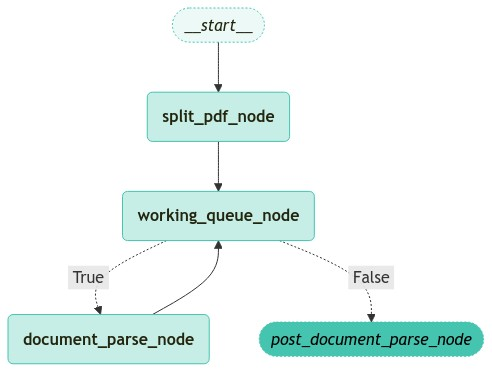

In [10]:
from layoutparse.teddynote_parser import create_upstage_parser_graph

# 그래프 생성
upstage_parser_graph = create_upstage_parser_graph(
    batch_size=30, test_page=None, verbose=True, visualize=True
)

### `upstage_parser_graph` 사용

- `filepath`: 분석할 PDF 파일의 경로

In [14]:
import uuid
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph

# 옵션 설정
config = RunnableConfig(
    recursion_limit=300,
    configurable={"thread_id": str(uuid.uuid4())},
)

# filepath: 분석할 PDF 파일의 경로
inputs = {
    "filepath": "data/pdf_data/middle_gate.pdf",
}

stream_graph(upstage_parser_graph, inputs, config=config)

[SplitPDFNode] 파일의 전체 페이지 수: 15 Pages.
[SplitPDFNode] 분할 PDF 생성: data/pdf_data/middle_gate_0000_0014.pdf
[DocumentParseNode] Start Parsing: data/pdf_data/middle_gate_0000_0014.pdf
[DocumentParseNode] Finished Parsing in 14.58 seconds
[PostDocumentParseNode] Total Post-processed Elements: 123
[PostDocumentParseNode] Total Cost: $0.15


In [ ]:
# 추출된 요소들을 확인합니다
elements = upstage_parser_graph.get_state(config).values["elements_from_parser"]
elements[-20:]

## Export 처리 로직 구성

이전 단계의 State 를 재사용하기 때문에 **모듈 단위로 이어서 개발하기가 용이**합니다.

In [ ]:
# 그래프 처리를 위한 필수 라이브러리들을 임포트합니다
from langgraph.graph import StateGraph, END
from layoutparse.state import ParseState
import layoutparse.export as export
from langchain_teddynote.graphs import visualize_graph

"""
후처리 워크플로우를 생성하고 관리하는 클래스입니다.
이미지, HTML, 마크다운, CSV 등 다양한 포맷으로 변환하는 작업을 처리합니다.
"""

# ParseState를 상태 관리자로 사용하는 StateGraph 인스턴스를 생성합니다
export_workflow = StateGraph(ParseState)

# 각각의 export 컴포넌트들을 verbose 모드로 초기화합니다
export_image = export.ExportImage(verbose=True)  # 이미지 export 담당
export_html = export.ExportHTML(verbose=True)  # HTML export 담당
export_markdown = export.ExportMarkdown(verbose=True)  # 마크다운 export 담당
export_table_csv = export.ExportTableCSV(verbose=True)  # CSV export 담당

# 워크플로우에 각 컴포넌트들을 노드로 추가합니다
export_workflow.add_node("export_image", export_image)
export_workflow.add_node("export_html", export_html)
export_workflow.add_node("export_markdown", export_markdown)
export_workflow.add_node("export_table_to_csv", export_table_csv)

# export_image 노드에서 다른 노드들로 연결되는 엣지를 추가합니다
export_workflow.add_edge("export_image", "export_html")
export_workflow.add_edge("export_image", "export_markdown")
export_workflow.add_edge("export_image", "export_table_to_csv")

# 각 export 노드에서 END로 연결되는 엣지를 추가합니다
export_workflow.add_edge("export_html", END)
export_workflow.add_edge("export_markdown", END)
export_workflow.add_edge("export_table_to_csv", END)

# 워크플로우의 시작점을 export_image로 설정합니다
export_workflow.set_entry_point("export_image")

# 워크플로우를 컴파일하고 시각화합니다
export_graph = export_workflow.compile()
visualize_graph(export_graph)

In [ ]:
# 이전 단계의 실행 결과를 사용합니다
previous_state = upstage_parser_graph.get_state(config).values

In [ ]:
# 추출된 요소들을 확인합니다
previous_state["elements_from_parser"][:10]

In [ ]:
# 이전 단계의 실행 결과를 복사하여 입력으로 사용합니다
inputs = previous_state.copy()

매번 최신 코드를 반영하기 위한 `importlib` 

In [ ]:
import importlib

# export 모듈을 새로 리로드하여 최신 상태를 유지합니다
importlib.reload(export)

# 각각의 export 컴포넌트들을 verbose 모드로 초기화합니다
export_image = export.ExportImage(verbose=True)
export_html = export.ExportHTML(verbose=True, ignore_new_line_in_text=True)
export_markdown = export.ExportMarkdown(
    verbose=True, ignore_new_line_in_text=True, show_image=True
)
export_table_csv = export.ExportTableCSV(verbose=True)

단계별 상태를 업데이트 후 반영합니다.

In [ ]:
inputs2 = export_image(inputs)
inputs.update(inputs2)

In [ ]:
# 반영된 결과
inputs["elements_from_parser"][-30:-25]

In [ ]:
export_html(inputs)

입력으로 들어가는 상태 확인

In [ ]:
inputs["elements_from_parser"][0]

### Markdown

In [ ]:
export_markdown(inputs)

### CSV

In [ ]:
export_table_csv(inputs)

In [ ]:
# 추출된 요소들을 확인합니다
previous_state["images_by_page"]